**THIS NOTEBOOK CONTAINS SARIMAX MODEL TO FORECAST PAYMENT AMOUNT FROM INVOICE DATA FOR NEXT 6 MONTHS.**

In [1399]:
#Importing the prerequisite libraries that are to be used further.
import pandas as pd
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import matplotlib.pyplot as plt

**Below is importing the sells data and invoice data.**

In [1400]:
sales=pd.read_csv("sales_receipt.csv")
invoice=pd.read_csv("seller_buyer_paymentdetails.csv")

In [1402]:
invoice=invoice[["TransactionDate","SellerId","Trans_amount"]]

**Removing NaN values from the invoice data.**

In [1403]:
invoice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86319 entries, 0 to 86318
Data columns (total 3 columns):
TransactionDate    86319 non-null object
SellerId           86319 non-null int64
Trans_amount       86319 non-null int64
dtypes: int64(2), object(1)
memory usage: 2.0+ MB


**Below is the sample of invoice data.**

In [1404]:
invoice.head()

,TransactionDate,SellerId,Trans_amount
0,2019-03-15T00:00:00.000Z,19,10000
1,2017-04-18T00:00:00.000Z,19,5000000
2,2019-07-18T00:00:00.000Z,1,5000
3,2019-07-18T00:00:00.000Z,1,13000
4,2019-07-18T00:00:00.000Z,1,17500


**Below is the preparation of data for forecasting.**

In [1405]:
sales["TransactionDate"]=pd.to_datetime(pd.to_datetime(sales.TransactionDate).dt.date)
invoice["TransactionDate"]=pd.to_datetime(pd.to_datetime(invoice.TransactionDate).dt.date)

**Below is extracting columns that are needed.**

In [1406]:
sales_fin=sales[["TransactionDate","SellerId", "Amount"]]
invoice_fin=invoice[["TransactionDate","SellerId","Trans_amount"]]

<font color="red">**SARIMAX ON INVOICE DATA**</font>

**Extracting SellerId 5 for further forecasting.**

In [1407]:
data=invoice_fin[invoice_fin["SellerId"]==14][["TransactionDate","Trans_amount"]]
data=data.set_index("TransactionDate")
data=data.groupby(pd.Grouper(freq="M")).sum()

**Below is the sample data.**

In [1408]:
data.head()

,Trans_amount
TransactionDate,
2016-01-31,19512595
2016-02-29,23354378
2016-03-31,22636464
2016-04-30,14835866
2016-05-31,29907749


**Below is function to test stationarity of the series.**

In [1409]:
from statsmodels.tsa.stattools import adfuller
def dft(ts):
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test_stats','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return(dfoutput)

**This test shows us that data is stationary but seasonal.**

In [1359]:
dft(data.Tr_Amount)

Test_stats                    -7.019963e+00
p-value                        6.582128e-10
#Lags Used                     0.000000e+00
Number of Observations Used    4.200000e+01
Critical Value (1%)           -3.596636e+00
Critical Value (5%)           -2.933297e+00
Critical Value (10%)          -2.604991e+00
dtype: float64

**Importing requisite libraries for running of model.**

In [1360]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import random

**Below is preparing the exgogenous data for training the model.**

In [1361]:
data1=pd.DataFrame()
data1["Amount"]=data.Trans_amount.apply(lambda x: x*0.1)

**Training the SARIMAX model by using data1 above as the exogenous data.**

In [1362]:
model = SARIMAX(data.Pay_Amount, exog=data1, order=(1, 0, 1), seasonal_order=(1,0,1,1))

**Fitting the model.**

In [1363]:
model_fit = model.fit()

**Preparing the exogenous data for predicting the outcome.**

In [1364]:
data2=pd.DataFrame()
data2["Amount"] = data.Trans_amount.head(5).apply(lambda x:x*0.1)

In [1365]:
data2.Amount.max()

2990774.9000000004

**Predicting the amount using data2 above as exogenous data for the model.**

In [1366]:
predict=model_fit.predict(start="2019-07-31", end="2019-12-31", exog=data2, dynamic=False)

**Below are the predicted values for the amount.**

In [1367]:
predict

2019-07-31    4.495489e+06
2019-08-31    1.877824e+07
2019-09-30    2.242917e+07
2019-10-31    2.173093e+07
2019-11-30    1.424120e+07
2019-12-31    2.870786e+07
Freq: M, dtype: float64

**Preparing the dataframe of predicted values.**

In [1368]:
def pred_fin(predicted, train):
    c=pd.Index(predicted.index)
    c=c.insert(0, pd.to_datetime(train.index[-1]))
    lis=list(predicted.values)
    lis.insert(0,train[-1])
    lis=pd.Series(lis,index=c)
    prediction_final=lis.apply(lambda x:int(x))
    return prediction_final

**Making the dataframe of predicted values by the model.**

In [1369]:
pred_df=pd.DataFrame()
id=pd.date_range("2019-07-31","2019-12-31", freq="M")
pred_df["TransactionDate"]=id
pred_df["Pay_amount"]=predict.values
pred_df=pred_df.set_index("TransactionDate")

In [1370]:
pred_df=pred_df.drop(pred_df.index[0])

**Below is function making the forecast continuous with the training set.**

In [1371]:
pred_final=pred_fin(pred_df.Pay_amount, data.Pay_Amount)

**following is the final forecast by the model.**

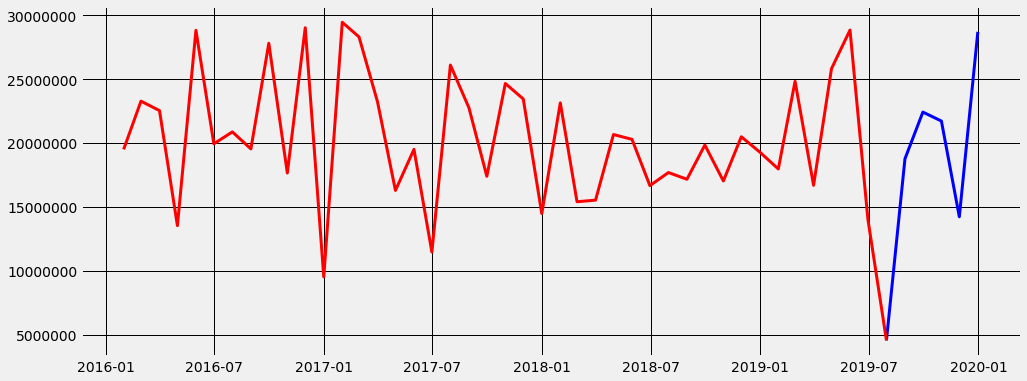

In [1374]:
plt.figure(figsize=(15,6))
plt.plot(pred_final, color="blue", linewidth=3)
plt.plot(data.Pay_Amount, color="red", linewidth=3)
plt.gca().get_yaxis().get_major_formatter().set_scientific(False)
plt.grid(True, color="black")
plt.show()

<font color="red">**SARIMAX MODEL ON SALES DATA.**</font>

**Importing the sales data for seller 5 and extracting TransactionDate and Amount.**

In [1375]:
data=sales_fin[sales_fin["SellerId"]==5][["TransactionDate","Amount"]]
data=data.set_index("TransactionDate")
data=data.groupby(pd.Grouper(freq="M")).sum()

**Importing libraries for SARIMAX model.**

In [1376]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import random

**Sample of the data.**

In [1377]:
data.head()

,Amount
TransactionDate,
2016-01-31,509250
2016-02-29,1291250
2016-03-31,1894350
2016-04-30,1650750
2016-05-31,342500


**Below is the preparation of exogenous data for fitting the model.**

In [1379]:
data1=pd.DataFrame()
data1["Amount"]=data.Amount.apply(lambda x: 0.1*x)

**Preparing the SARIMAX model by using data1 above as the exogenous part.**

**The seasonal orders have been iteratively found.**

In [1381]:
model = SARIMAX(data, exog=data1, order=(1, 0, 1), seasonal_order=(1,0,1,6))

In [1382]:
model_fit = model.fit()

**Preparing the exogenous data for prediction.**

In [1384]:
data2=pd.DataFrame()
data2["Amount"] = sales_fin.Amount.tail(5).apply(lambda x:x*0.1)

**Predicting the amount for coming 6 months by using data2 above as exogenous data.**

In [1385]:
predict=model_fit.predict(start="2019-07-31", end="2019-12-31", exog=data2, dynamic=False)

**Making dataframe of predicted values.**

In [1386]:
pred_df=pd.DataFrame()
id=pd.date_range("2019-07-31","2019-12-31", freq="M")
pred_df["TransactionDate"]=id
pred_df["Amount"]=predict.values
pred_df=pred_df.set_index("TransactionDate")

**Below function is used to make the forecast and training data continuous.**

In [1387]:
def pred_fin(predicted, train):
    c=pd.Index(predicted.index)
    c=c.insert(0, pd.to_datetime(train.index[-1]))
    lis=list(predicted.values)
    lis.insert(0,train[-1])
    lis=pd.Series(lis,index=c)
    prediction_final=lis.apply(lambda x:int(x))
    return prediction_final

In [1388]:
pred_final=pred_fin(pred_df.Amount, data.Amount)

**Following is the forecast of amount for sells data.**

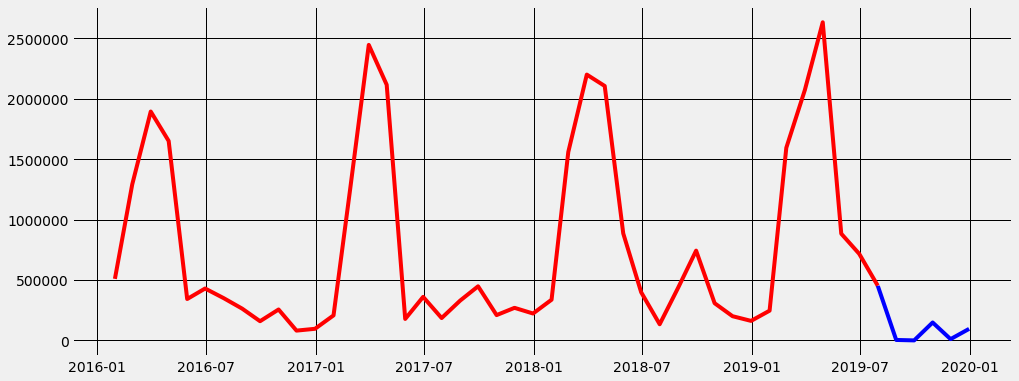

In [1389]:
plt.figure(figsize=(15,6))
plt.plot(pred_final, color="blue")
plt.plot(data.Amount, color="red")
plt.grid(True, color="black")
plt.show()